# TP2 - SD-TSIA211
## Júlia Togashi de Miranda/ Gabriel Medeiros

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd

In [2]:
def load_breastcancer(filename):
    """
    Cette fonction lit le fichier filename, par exemple
    filename = 'wdbc_M1_B0.data'
    Elle retourne 
    X : une matrice de caracteristiques
    y : un vecteur des classes tel que si y[i] = 1, la tumeur est maligne
        et si y[i] = -1, la tumeur est benigne

    Pour plus d'infos sur la base de donnees,
    https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Prognostic%29
    """

    data = np.loadtxt(filename, delimiter=',')

    # la colonne 0 ne nous interesse pas ici
    y = data[:, 1] * 2 - 1
    X = data[:, 2:]

    # Standardisation de la matrice
    X = X - np.mean(X, axis=0)
    X = X / np.std(X, axis=0)

    return X, y


In [3]:
X, y = load_breastcancer('wdbc_M1_B0.data.txt')

## Notation
$$y_i \in \mathbb{R}, Y = [y_1, ..., y_n]^T \in \mathbb{R}^n$$

$$v \in \mathbb{R}^m$$

$$x_i \in \mathbb{R}^m, X = [x_1^T, ..., x_n^T]^T \in \mathbb{R}^{(n,m)}$$

Therefore: 

$$x_i^Tv \in \mathbb{R}, Xv \in \mathbb{R}^n$$

## 2.1

Considering the optimization problem is:
$$ min \frac{1}{2} \sum_{j=1}^{m}v_j^2 + c \sum_{i=1}^{n}\xi_j$$

where, $\forall i \in \{1, ..., n\}$:

$$ \xi \geq 0$$
$$ \xi \geq 1- y_i(x_i^Tv+a)$$

Because of the constraints, $\xi_i$ has a minimum value, which would be the smallest possible value for which both constraints are satisfied. Which is obtained by $max(0, 1- y_i(x_i^Tv+a))$. Since the original function asks to be minimized, it would be equivalent to:
$$ min \frac{1}{2} \sum_{j=1}^{m}v_j^2 + c \sum_{i=1}^{n}max(0, 1- y_i(x_i^Tv+a))$$

## 2.2
Defining $h(z) = max(0, 1-z)$ the resulting plot is:

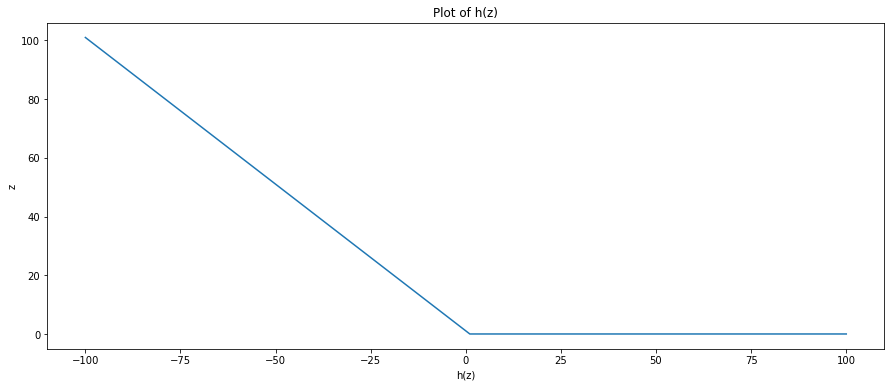

In [4]:
def h(z):
    return np.maximum(0,1-z)

Z= np.arange(-100,100,0.001)
H=[]
for i in Z:
    H.append(h(i))

plt.figure(figsize=(15, 6))
plt.plot(Z,H)
plt.title('Plot of h(z)')
plt.ylabel("z")
plt.xlabel("h(z)")
plt.show()

From the figure above it is possible to see that between $[-100, 0]$ the slope is -1, also from $[0, 100]$ the slope is null, so it's derivate is equal to zero. Therefore, on the its slope is contained in $[0, 1]$. 


## 2.3

The function $f(v,a)=\frac{1}{2}\sum_{j=1}^{m}v_j^2+c\sum_{i=1}^{n}max(0,1-y_i(x_i^Tv+a))$, can be split into two functions $f(v,a) = N(v,a) + cH(M(v,a))$, as the following:

$$N(v,a) = \frac{1}{2}\sum_{j=1}^{m}v_j^2 $$
And:
$$H(M(v,a))= \sum_{i=1}^{n}max(0,1-y_i(x_i^Tv+a)) = \sum_{i=1}^{n}max(0,1-M(v, a))$$

Considering the transformation M:

$$M(v,a) =diag(y)(Xv+a), M(v, a) \in \mathbb{R}^n$$

Therefore M:

$$M = Diag(y)[X, \mathbb{1}]$$

Using preposition 2.4.2, the sub-gradient of f can de defined as:

$$\partial f(v,a)=\partial N(v,a) +cM^T\partial H(M(v,a))$$

Where:

$$\partial N(v,a) = \sum_{j=1}^{m}v_j, \partial N(v,a) \in \mathbb{R} $$

And $ \partial H(M(v,a)) $ is equal to the sub-gradient of h(z) in question 2.2, thus 
$\partial H_i(M(v,a)) = \begin{cases} 
      \{-1\} &, M_i(v,a) < 1 \\
      \{0\} &, M_i(v,a) > 1 \\
      [-1,0] &, M_i(v,a) = 1
\end{cases}$

To conclude:

$$\partial f(v,a)=\partial N(v,a) +cM^T\partial H(M(v,a))$$

Where:

$$\partial f_i(v,a) = \begin{cases} 
      \partial N_i(v,a) - cM^T & ,M_i(v,a) < 1 \\
      \partial N_i(v,a) & ,M_i(v,a) > 1 \\
      \partial N_i(v,a) + [- cM^T, 0] & ,M_i(v,a) = 1
\end{cases}$$


## 2.4

In [5]:
def f(v, a, c, X, y):
    #finding N(v, a)
    N = np.sum(v[:]**2)/2 
    
    #finding H(v, a)
    H = 0
    for i in range(len(y)):
        z = y[i]*(X[i]@v+a)
        H = H + max(0, 1-z)
    H = H*c
    
    return N + H

In [6]:
def par(va, c, M):
    #dN alters the value to be added to each v but not to a, therefore its va but without a
    dN = va
    dN[-1]=0
    
    #According to 2.3:
    #if M@va is bigger than 1 then its supposed to be zero. If its smaller than 1 then its supposed to be -1
    #The resulting matrix gets multiplied by M.T
    dH = (M@va>=1)- 1
    dH = M.T@dH
    
    return dN + c*dH

## 2.5


In [9]:
def grad_desc(a, v):
    k=0
    c=1
    M = np.diag(y)@np.concatenate([X, np.ones((np.shape(X)[0],1))], axis = 1)
    va = np.concatenate([v, [a]])
    for k in range(10000):
        gam = 1/(k+1)
        va = va - gam*par(va, c, M)
    return va

In [10]:
va = grad_desc(0, np.zeros(np.shape(X)[1]))

In [11]:
print(f'The minimizing point obtained was: {f(va[:-1], va[-1], 1, X, y):.3f}')

The minimizing point obtained was: 26.546


## 3.1

Let I be a random uniform variable {1,...,n}, therefore, it can be proved that: $f(v,a) = \mathbb{E}[f_I(v,a)] $ as follows: 

$$\mathbb{E}[f_I(v,a)] = \sum_{i=1}^n \mathbb{P}(I = i)f_i(v,a)$$

As I follows a uniform law:

$$\mathbb{E}(f_I(v,a)) = \frac{1}{n} \sum_{i=1}^n f_i(v,a)$$

Where:

$$f_i(v,a) = \frac{1}{2}\sum_{j=1}^m v_j^2 + cn \max(0,1-y_i(x_i^Tv+a)$$

So:

$$\mathbb{E}(f_I(v,a)) = \frac{1}{n} \sum_{i=1}^n \left(\frac{1}{2}\sum_{j=1}^m v_j^2 + cn \max(0,1-y_i(x_i^Tv+a) \right)$$

$$\mathbb{E}(f_I(v,a)) = \frac{1}{2} \sum_{j=1}^m v_j^2 + \frac{1}{n}\sum_{i=1}^n cn \max(0,1-y_i(x_i^Tv + a))$$

$$\mathbb{E}(f_I(v,a)) = \frac{1}{2} \sum_{j=1}^m v_j^2 + c \sum_{i=1}^n max(0,1-y_i(x_i^Tv + a))$$

Proving that:

$$\mathbb{E}(f_I(v,a)) = f(v,a)$$

## 3.2

Given the M matrix defined in question 2.3, the $i^{th}$ line of the matrix M(v,a) is: $ M_i(v,a)=y_i(x_i^Tv+a) $

$f_i(v,a)$ can be decomposed similary to $f(v,a)$ as follows:

$$f_i(v,a) = N(v,a) + cn H(M_i(v,a))$$

Where:

$$N(v,a) = \frac{1}{2}\sum_{j=1}^m v_j^2 $$

$$H(z) = \max(0,1-z)$$

Again, using preposition 2.4.2, the sub-gradient of f can de defined as:

$$\partial f(v,a)=\partial N(v,a) +cnM_i^T\partial H(M_i(v,a))$$

therefore, the subdiferential with respect to v:

$$\frac{\partial f_i(v,a)}{\partial v}= \begin{cases} 
      v - cn(m_i)_{0} &, M_i(v,a) < 1 \\
      v &, M_i(v,a) > 1 \\
      [v - cn(m_i)_{0},v] &, M_i(v,a) = 1
\end{cases}$$


And the subdiferential with respect to a:

$$\frac{\partial f_i(v,a)}{\partial a}= \begin{cases} 
      -cn(m_i)_{1}&, M_i(v,a) < 1 \\
      0 &, M_i(v,a) > 1 \\
      [-cn(m_i)_{1},0] &, M_i(v,a) = 1
\end{cases}$$


## 3.3

The objective is to compute the stochastic subgradient method in order to solve Problem (2).

The stochastic gradient method has been designed to solve the optimization problem:

$$\min_{x \in X} \mathbb{E}(f(x,\xi))$$

As $f(v,a) = \mathbb{E}[f_I(v,a)]$ , we can solve Problem (2) by solving the stochastic gradient method in $\mathbb{E} [f_I(v,a)]$

At first, the functions to compute the subgradien of $f_i(a,b)$:

In [13]:
def subgrad_f_i(v, a, c, x, y):  
    # Here y should be a scalar, equal to the i_th entry of vector Y belonging R^n.
    # x should be a vector belonging to R^m, equal to the i_th entry of matrix X belonging to R^nxm
    
    # This functuion computes the value of the subgradient function for one sigle observation i.
    gradv = v
    grada = 0
    
    if y*(x@v+a) < 1:
        gradv = gradv - c* X.shape[0]* y*x
        grada = grada - c* X.shape[0]* y
    return  gradv,grada

Now for the stochastic subgradient method :

In [18]:
def stoch(a, v):
    gam_sum=0
    va_sum= np.zeros(np.shape(X)[1]+1)
    va = np.concatenate([v, [a]])
    
    for i in range(100000):
        
        gam = 1/(i+1)
        k = np.random.randint(y.size)
        
        vn, an = subgrad_f_i(va[:-1], va[-1], 1, X[k], y[k])
        va = va - gam * np.concatenate([vn, [an]])

    return va

In [19]:
va =stoch(0.0, np.zeros(np.shape(X)[1]))
print(f'The minimizing point obtained was: {f(va[:-1], va[-1], 1, X, y):.3f}')

The minimizing point obtained was: 29.104
